In [1]:
%run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:0,



In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # set as the using GPU ID

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>
</div>


In [4]:
# Define the transformation to apply to each image in the dataset
# - transforms.ToTensor(): Converts the images to PyTorch tensors
# - transforms.Normalize(): Normalizes the images with mean and standard deviation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the batch size for loading data
batch_size = 4

# Load the CIFAR-10 training dataset
# - root: Directory to store the dataset
# - train: True means loading the training set
# - download: True means the dataset will be downloaded if not available locally
# - transform: Applies the defined transformations to the dataset
trainset = torchvision.datasets.CIFAR10(root='/Desktop/CodeFolder/PCS/dataset', train=True,
                                        download=True, transform=transform)

# Create a data loader for the training set
# - batch_size: Number of samples per batch
# - shuffle: True means the data will be shuffled (randomly mixed)
# - num_workers: Number of subprocesses to use for data loading
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test dataset
# - train: False means loading the test set
# - download: True means the dataset will be downloaded if not available locally
# - transform: Applies the defined transformations to the dataset
testset = torchvision.datasets.CIFAR10(root='/Desktop/CodeFolder/PCS/dataset', train=False,
                                       download=True, transform=transform)

# Create a data loader for the test set
# - batch_size: Number of samples per batch
# - shuffle: False means the data will not be shuffled
# - num_workers: Number of subprocesses to use for data loading
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the class names in the CIFAR-10 dataset
# These are the labels for the 10 different classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.


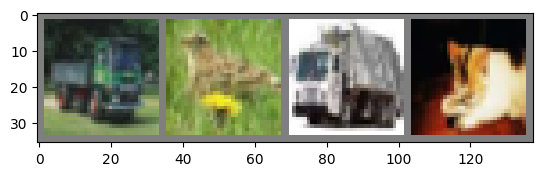

truck bird  truck cat  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Use GPU

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [17]:
import torch.nn as nn
import torch.nn.functional as F


# Define the neural network by inheriting from nn.Module
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the first convolutional layer
        # - in_channels: Number of input channels (3 for RGB images)
        # - out_channels: Number of output channels (6 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Define a max-pooling layer
        # - kernel_size: Size of the pooling window (2x2)
        # - stride: Step size for the window (2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the second convolutional layer
        # - in_channels: Number of input channels (6 from previous conv layer)
        # - out_channels: Number of output channels (16 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Define the first fully connected layer
        # - in_features: Number of input features (16 * 5 * 5 from previous layers)
        # - out_features: Number of output features (120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        # Define the second fully connected layer
        # - in_features: Number of input features (120)
        # - out_features: Number of output features (84)
        self.fc2 = nn.Linear(120, 84)
        
        # Define the third fully connected layer
        # - in_features: Number of input features (84)
        # - out_features: Number of output features (10, for 10 classes)
        self.fc3 = nn.Linear(84, 10)

    # Define the forward pass
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Apply the second convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor, keeping the batch dimension
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        # Apply the third fully connected layer to produce the final output
        x = self.fc3(x)
        
        return x

# Create an instance of the neural network and move it to the specified device (CPU or GPU)
net = Net().to(device)

3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [19]:
# Train the network for a specified number of epochs (here, 2 epochs)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0  # Initialize the running loss for each epoch
    for i, data in enumerate(trainloader, 0):
        # Get the inputs and labels from the data loader
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Move the inputs and labels to the specified device (CPU or GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients to avoid accumulation from previous iterations
        optimizer.zero_grad()

        # Perform the forward pass: compute the network's outputs
        outputs = net(inputs)
        
        # Compute the loss using the criterion
        loss = criterion(outputs, labels)
        
        # Perform the backward pass: compute the gradients
        loss.backward()
        
        # Update the network parameters using the optimizer
        optimizer.step()

        # Accumulate the loss for the current mini-batch
        running_loss += loss.item()
        
        # Print statistics every 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0  # Reset the running loss for the next set of mini-batches

print('Finished Training')

[1,  2000] loss: 2.227
[1,  4000] loss: 1.929
[1,  6000] loss: 1.704
[1,  8000] loss: 1.594
[1, 10000] loss: 1.538
[1, 12000] loss: 1.486
[2,  2000] loss: 1.451
[2,  4000] loss: 1.376
[2,  6000] loss: 1.345
[2,  8000] loss: 1.348
[2, 10000] loss: 1.323
[2, 12000] loss: 1.288
Finished Training


Let\'s quickly save our trained model:


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


# We wont use GPU for testing, as we dont have to do update the model.

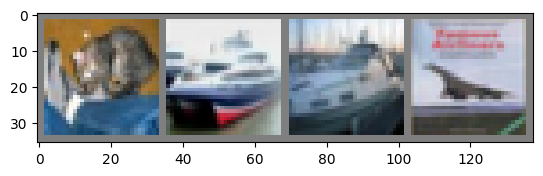

GroundTruth:  cat   ship  ship  plane


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [23]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [26]:
# Prepare dictionaries to count correct and total predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:
        # Get the inputs and labels from the data loader
        images, labels = data
        
        # Move the inputs to the specified device (CPU or GPU)
        images = images
        
        # Perform the forward pass: compute the network's outputs
        outputs = net(images)
        
        # Get the predicted class with the highest score
        _, predictions = torch.max(outputs, 1)
        
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 57.3 %
Accuracy for class: car   is 68.4 %
Accuracy for class: bird  is 39.2 %
Accuracy for class: cat   is 36.7 %
Accuracy for class: deer  is 53.6 %
Accuracy for class: dog   is 21.5 %
Accuracy for class: frog  is 74.9 %
Accuracy for class: horse is 59.9 %
Accuracy for class: ship  is 76.6 %
Accuracy for class: truck is 49.9 %
